In [37]:
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.transforms.functional import to_tensor, to_pil_image
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from tqdm import tqdm

In [38]:
def normalize(image):
  return image


def resize(image):
  im = torch.zeros(1, 32, 32)
  im[:, 2:30, 2:30] = image
  return im

In [77]:
train_dataset = MNIST(root="data", download=True, transform=Compose([ToTensor(), normalize, resize]))
test_dataset = MNIST(root="data", download=True, train=False, transform=Compose([ToTensor(), normalize, resize]))
train_data = DataLoader(train_dataset, batch_size=256)
test_data = DataLoader(test_dataset, batch_size=256)

In [40]:
image, label = train_dataset[10]

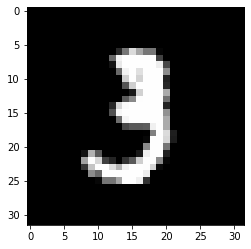

In [41]:
plt.imshow(image.numpy()[0], cmap="gray", vmin=0, vmax=1)
plt.show()

In [7]:
class PCNet1(nn.Module):
    def __init__(self, num_channels=1, input_size=(28, 28), num_iter=4):
        super(PCNet1, self).__init__()
        self.num_iter = num_iter
        self.input_size = input_size
        
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        
        self.fc1 = nn.Linear(26 * 26 * 32, 128) # Lose structure here
        self.fc2 = nn.Linear(128, 26 * 26 * 32)
        
        #self.latent = nn.Conv2d(32, 32, kernel_size=5)
        
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1)
        self.deconv2 = nn.ConvTranspose2d(16, num_channels, kernel_size=3, stride=1)
        
    def forward(self, x1):
        # Easy way to construct error units with correct sizes.
        with torch.no_grad():
            x1_pred = torch.zeros_like(x1)
            x2_pred = self.conv1(x1_pred)
            x3_pred = self.conv2(x2_pred)
            x4_pred = self.fc1(x3_pred.flatten(start_dim=1))
        
        # Rollout
        x1_preds = [x1_pred.clone()] # Store history of predictions
        
        for i in range(self.num_iter):
            # Bottom-up signal is inhibited by top-down
            e1 = F.relu(x1 - x1_pred) 
            x2 = self.conv1(e1)
            e2 = F.relu(x2 - x2_pred)
            x3 = self.conv2(e2)
            e3 = F.relu(x3 - x3_pred)
            
            x4 = self.fc1(e3.flatten(start_dim=1))
            x4_pred = F.relu(x4 - x4_pred) # This just seems to be alternating? Maybe add some decay?
            
            # Top-down
            e3_pred = F.relu(x4_pred - x4)
            x3_pred = self.fc2(e3_pred).view(x3.shape)
            e2_pred = F.relu(x3_pred - x3)
            x2_pred = self.deconv1(e2_pred)
            e1_pred = F.relu(x2_pred - x2)
            x1_pred = self.deconv2(e1_pred)
            
            x1_preds.append(x1_pred.clone())
            
        return x1_pred, x1_preds # Return predicted input along with its history.

In [8]:
class PCNet(nn.Module):
    """
        Changes from original:
            - Removed inhibation of top-down signal.
            #- Remember latent over time steps.
    """
    def __init__(self, num_channels=1, input_size=(28, 28), num_iter=2):
        super(PCNet, self).__init__()
        self.num_iter = num_iter
        self.input_size = input_size
        
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        
        self.fc1 = nn.Linear(26 * 26 * 32, 128) # Lose structure here
        self.fc2 = nn.Linear(128, 26 * 26 * 32)
        
        #self.latent = nn.Conv2d(32, 32, kernel_size=5)
        
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1)
        self.deconv2 = nn.ConvTranspose2d(16, num_channels, kernel_size=3, stride=1)
        
    def forward(self, x1):
        # Easy way to construct error units with correct sizes.
        with torch.no_grad():
            x1_pred = torch.zeros_like(x1)
            x2_pred = self.conv1(x1_pred)
            x3_pred = self.conv2(x2_pred)
            latent = self.fc1(x3_pred.flatten(start_dim=1))
        
        # Rollout
        x1_preds = [] # Store history of predictions
        
        for i in range(self.num_iter):
            # Bottom-up signal is inhibited by top-down
            e1 = F.relu(x1 - x1_pred) 
            x2 = self.conv1(e1)
            e2 = F.relu(x2 - x2_pred)
            x3 = self.conv2(e2)
            e3 = F.relu(x3 - x3_pred)
            
            x4 = self.fc1(e3.flatten(start_dim=1))
            latent = 0.5 * latent + 0.5 * F.relu(x4 - latent) # This just seems to be alternating? Maybe add some decay?
            
            # Top-down
            x3_pred = F.relu(self.fc2(latent).view(x3.shape))
            x2_pred = F.relu(self.deconv1(x3_pred))
            x1_pred = torch.sigmoid(self.deconv2(x2_pred))
            
            x1_preds.append(x1_pred.clone())
            
        return x1_pred, x1_preds # Return predicted input along with its history.

In [9]:
model = PCNet()

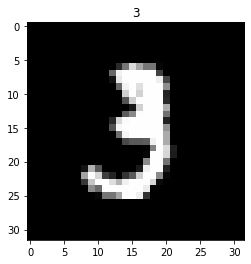

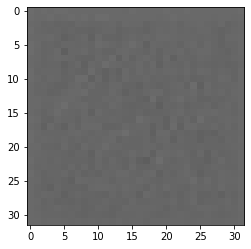

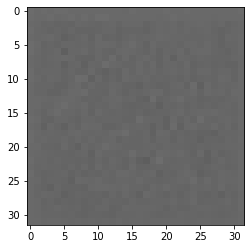

In [10]:
image, label = train_dataset[10]
plt.title(label)
plt.imshow(image[0], cmap="gray", vmin=0, vmax=1)
plt.show()

_, pred_images = model(image[None, :])
for pred_image in pred_images:
    
    plt.imshow(pred_image[0].detach().numpy()[0], cmap="gray", vmin=0, vmax=1)
    plt.show()

# Training

Epoch: 1, Loss: 0.5533:   0%|          | 0/1875 [00:00<?, ?it/s]

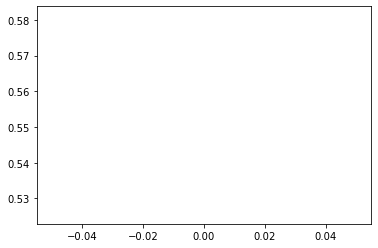

Epoch: 1, Loss: 0.5505:   0%|          | 1/1875 [00:01<24:51,  1.26it/s]

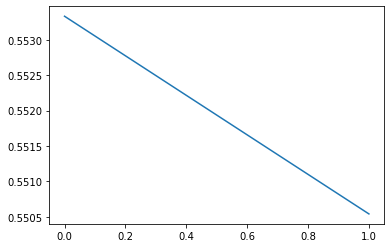

Epoch: 1, Loss: 0.5471:   0%|          | 2/1875 [00:01<21:46,  1.43it/s]

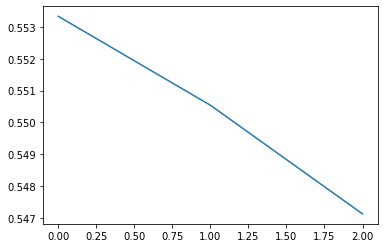

Epoch: 1, Loss: 0.5430:   0%|          | 3/1875 [00:02<19:18,  1.62it/s]

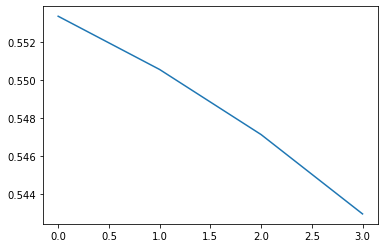

Epoch: 1, Loss: 0.5369:   0%|          | 4/1875 [00:03<20:07,  1.55it/s]

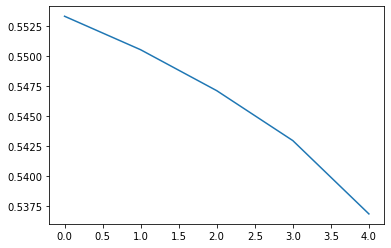

Epoch: 1, Loss: 0.5372:   0%|          | 5/1875 [00:04<19:44,  1.58it/s]

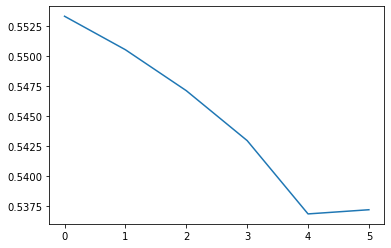

Epoch: 1, Loss: 0.5372:   0%|          | 6/1875 [00:04<24:31,  1.27it/s]


KeyboardInterrupt: 

In [11]:
num_epochs = 10
optimizer = SGD(model.parameters(), lr=1e-2)
criterion = nn.BCELoss()
loss_history = []

for epoch in range(num_epochs):
    tqdm_train_data = tqdm(train_data)
    for images, _ in tqdm_train_data:
        optimizer.zero_grad()
        pred_images, _ = model(images)
        loss = criterion(pred_images, images)
        
        loss.backward()
        loss_history.append(loss.item())
        
        tqdm_train_data.set_description("Epoch: {}, Loss: {:.4f}".format(epoch + 1, loss.item()))
        optimizer.step()
        
        plt.plot(loss_history)
        plt.show()
        

In [353]:
# Membrane time constant
T_RC = 0.02
T_REF = 4e-3
V_TH = 1.0

def rate(x, p=torch.relu, t_rc = 0.02, t_ref = 4e-3, V_th = 1.0):
  return torch.reciprocal(t_ref + t_rc * torch.log(1 + V_th / (p(x - V_th) + 1e-12)))

def soft_rate(x, t_rc = 0.02, t_ref = 4e-3, V_th = 1.0):
  return rate(x, p=lambda x: torch.nn.functional.softplus(x, beta=200), t_rc=t_rc, t_ref=t_ref, V_th=V_th)

In [277]:
soft_rate(torch.tensor(0.0))

tensor(2.6852)

In [278]:
x = torch.tensor([1000.0], requires_grad=True)
out = ((soft_rate(x) * T_RC) ** 2).mean()
out.backward()
x.grad

tensor([0.0002])

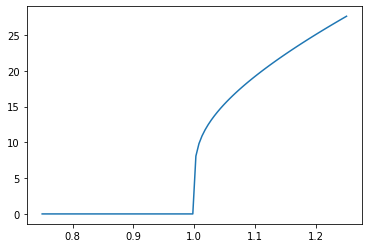

In [289]:

x = torch.linspace(0.75, 1.25, 100)
y = rate(x)
plt.plot(x, y)
plt.show()

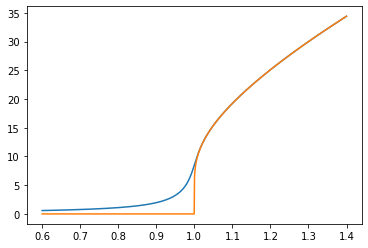

In [296]:
x = torch.linspace(0., 1.25, 100)
x = torch.linspace(0.6, 1.4, 1000)
y = soft_rate(x)
y2 = rate(x)
plt.plot(x, y)
plt.plot(x, y2)
plt.show()

In [311]:
soft_rate(torch.linspace(-250, 250, 1000)).mean()

tensor(114.9099)

In [605]:
import math
# Use this a activation function
class SoftSpikeRate(nn.Module):
  def __init__(self, t_rc=0.02, t_ref=4e-3, V_th=1.0):
    super(SoftSpikeRate, self).__init__()
    self.t_rc = torch.tensor(t_rc)
    self.t_ref = torch.tensor(t_ref)
    self.V_th = torch.tensor(V_th)
  
  def forward(self, X):
    return soft_rate(X, t_rc=self.t_rc, t_ref=self.t_ref, V_th=self.V_th)
  

class SpikeLayer(nn.Module):
  def __init__(self, in_features, out_features, t_rc=0.02, t_ref=4e-3, V_th=1.0, bound=1.0):
    super(SpikeLayer, self).__init__()
    # Initialize our weights
    self.A = nn.Parameter(torch.empty(in_features, out_features))
    self.b = nn.Parameter(torch.empty(out_features))
    self.t_rc = torch.tensor(t_rc)
    self.t_ref = torch.tensor(t_ref)
    self.V_th = torch.tensor(V_th)

    with torch.no_grad():
      nn.init.normal_(self.A)

  def forward(self, X):
    return soft_rate(X @ self.A, t_rc=self.t_rc, t_ref=self.t_ref, V_th=self.V_th) * self.t_rc

  
class SpikingLinear(nn.Module):
  def __init__(self, in_features, out_features, t_rc=0.02, t_ref=4e-3, V_th=1.0, bound=1.0):
    super(SpikingLinear, self).__init__()
    # Initialize our weights
    self.weight = nn.Parameter(torch.empty(in_features, out_features))
    self.b = nn.Parameter(torch.empty(out_features))
    self.t_rc = torch.tensor(t_rc)
    self.t_ref = torch.tensor(t_ref)
    self.V_th = torch.tensor(V_th)

    with torch.no_grad():
      n = in_features
      nn.init.normal_(self.weight, mean=-1/n, std=1/math.sqrt(2*n))

  def forward(self, X):
    return soft_rate(X @ self.weight, t_rc=self.t_rc, t_ref=self.t_ref, V_th=self.V_th)

class SpikingConv2d(nn.Conv2d):
  def __init__(self, in_channels, out_channels, kernel_size, *args, t_rc=0.02, t_ref=4e-3, V_th=1.0, bound=1.0, **kwargs):
    super().__init__(in_channels, out_channels, kernel_size, *args, **kwargs)
    self.t_rc = torch.tensor(t_rc)
    self.t_ref = torch.tensor(t_ref)
    self.V_th = torch.tensor(V_th)

    with torch.no_grad():
      n = in_channels * kernel_size * kernel_size
      nn.init.normal_(self.weight, mean=-1/n, std=1/math.sqrt(2*n))
    
  def forward(self, X):
    return soft_rate(super().forward(X), t_rc=self.t_rc, t_ref=self.t_ref, V_th=self.V_th)
    

class SpikingCNN(nn.Module):
  def __init__(self) -> None:
    super(SpikingCNN, self).__init__()
    self.model = nn.Sequential(
      SpikingConv2d(1, 64, 3),
      SpikingConv2d(64, 64, 3),
      nn.AvgPool2d(2, stride=2),
      #nn.BatchNorm2d(64),
      SpikingConv2d(64, 128, 3),
      SpikingConv2d(128, 128, 3),
      nn.AvgPool2d(2, stride=2),
      #nn.BatchNorm2d(128),
      SpikingConv2d(128, 256, 3),
      nn.AvgPool2d(2, stride=2),
      nn.Flatten(start_dim=1),
      #nn.BatchNorm1d(256),
      SpikingLinear(256, 10),
      nn.Softmax(dim=1)
    )

  def forward(self, X):
    return self.model(soft_rate(X * 5))
    
class BaselineCNN(nn.Module):
  def __init__(self) -> None:
    super(BaselineConv, self).__init__()
    self.model = nn.Sequential(
      nn.Conv2d(1, 64, 3),
      nn.ReLU(),
      nn.Conv2d(64, 64, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.BatchNorm2d(64),
      nn.Conv2d(64, 128, 3),
      nn.ReLU(),
      nn.Conv2d(128, 128, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.BatchNorm2d(128),
      nn.Conv2d(128, 256, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.Flatten(start_dim=1),
      nn.BatchNorm1d(256),
      nn.Linear(256, 10),
      nn.Softmax(dim=1)
    )

  def forward(self, X):
    return self.model(X)

class Baseline(nn.Module):
  def __init__(self) -> None:
    super(Baseline, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(32*32, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, 10),
      nn.Softmax(dim=1)
    )

  def forward(self, X):
    return self.model(X)

class SpikingMNISTModelWithLinear(nn.Module):
  def __init__(self) -> None:
    super(SpikingMNISTModelWithLinear, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(32*32, 256),
      SoftSpikeRate(),
      nn.Linear(256, 128),
      SoftSpikeRate(),
      nn.Linear(128, 10),
      SoftSpikeRate(),
      nn.Softmax(dim=1)
    )

  def forward(self, X):
    return self.model(X)


class SpikingMNISTModel(nn.Module):
  def __init__(self) -> None:
    super(SpikingMNISTModel, self).__init__()
    self.model = nn.Sequential(
      SpikeLayer(32*32, 256),
      SpikeLayer(256, 128),
      SpikeLayer(128, 10),
      nn.Softmax(dim=1)
    )

  def forward(self, X):
    return self.model(X)

In [593]:
nn.init

<module 'torch.nn.init' from '/zhome/87/0/137565/miniconda3/lib/python3.7/site-packages/torch/nn/init.py'>

In [594]:
torch.autograd.set_detect_anomaly(True)

In [595]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [617]:
model = SpikingCNN().to(device)
optimizer = SGD(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [597]:
soft_rate(torch.tensor(0))

tensor(1.7966)

In [652]:
soft_rate(torch.tensor(1))

tensor(8.5204)

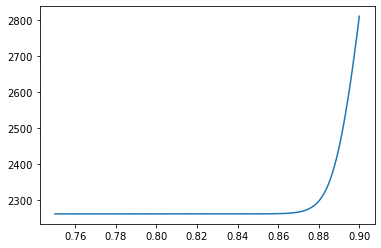

tensor(1.7966) tensor(0.)
tensor(1.8085) tensor(1.1476e-06)
tensor(1.8293) tensor(1.3494e-07)
tensor(1.9196) tensor(4.6353e-07)
tensor(2.8770) tensor(2.6934e-05)
tensor(34.8283) tensor(2.8677e-05)
tensor(192.0247) tensor(3.0897e-05)
tensor(237.3213) tensor(7.8393e-05)
tensor(239.6511) tensor(0.)
tensor(239.7480) tensor(4.5799e-05)
tensor([239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481,
        239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481,
        239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481,
        239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481,
        239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481,
        239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481,
        239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481,
        239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481, 239.7481,
        239.7481, 239.7481, 239.7481, 239.7

In [651]:
xs = torch.linspace(0.75, 0.9, 1000)
ys = ((soft_rate(soft_rate(xs)) - soft_rate(xs)) ** 2)

plt.plot(xs, ys)
plt.show()


n = 1000
w = torch.randn(n, n) * 0 + 0.49/n
a = torch.randn(n)
for i in range(10):
  a = soft_rate(a @ w)
  print(a.mean(), a.std())
  
print(a)

In [382]:
torch.random.randn()



test_model = nn.Sequential(
  SpikingConv2d(1, 10, 3),
  SpikingConv2d(10, 10, 3)
)

test_model(image[None, :]).max()

tensor(0.0072, grad_fn=<MaxBackward1>)

In [500]:
loss_history = []
num_epochs = 1

Testing...: 100%|██████████| 40/40 [00:05<00:00,  6.75it/s]


Accuracy: 9.80%


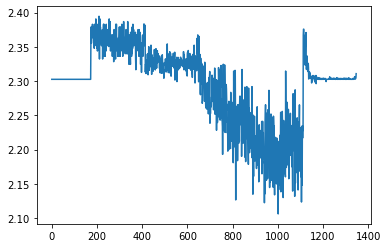

In [618]:
for epoch in range(num_epochs):
  # Train
  model.train()
  train_data_tqdm = tqdm(train_data)
  for i, (images, labels) in enumerate(train_data_tqdm):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()

    #images = images.view(-1, 32*32)
    preds = model(images)
    loss = criterion(preds, labels)
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()
    #if i % 10 == 0:
    train_data_tqdm.set_description("Training - Epoch: {}, Loss: {:.4f}".format(epoch + 1, loss.item()))
  
  # Test
  model.eval()
  test_data_tqdm = tqdm(test_data)
  test_data_tqdm.set_description("Testing...")
  num_correct = 0
  for (images, labels) in test_data_tqdm:
    images, labels = images.to(device), labels.to(device)
    pred_labels = model(images).argmax(dim=1)
    num_correct += torch.sum(pred_labels == labels).item()
    
  accuracy = num_correct / len(test_dataset) * 100
  print(f"Accuracy: {accuracy:.2f}%")

plt.plot(loss_history)
plt.show()

# Alpha filter

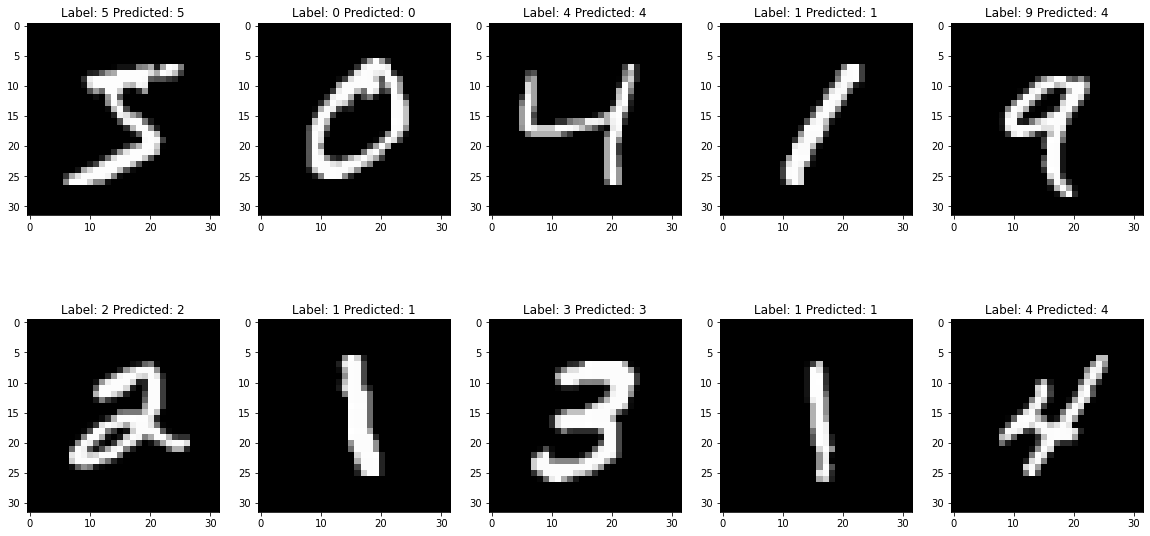

In [58]:
rows = 2
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

for row in range(rows):
  for col in range(cols):
    image, label = train_dataset[row * cols + col]
    out = model(image[None, :].to(device))

    axs[row][col].set_title("Label: {} Predicted: {}".format(label, out.argmax().item()))
    axs[row][col].imshow(image[0], cmap="gray")

In [525]:
def alpha_filter(t, t_s=0.003):
  return t / t_s * torch.exp(-t/t_s)

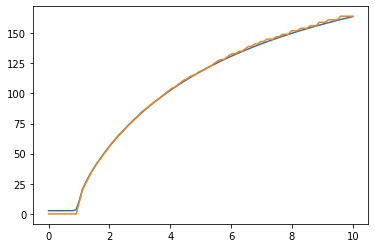

In [281]:
input_current = torch.linspace(0.0, 10, 100)
response = soft_rate(input_current)

secs = 1
dt = 1e-4
steps = int(secs / dt)
v = torch.zeros(100)
timeouts = torch.zeros(100)
vs = []
spikes = torch.zeros(steps, 100)
for i in range(steps):
  timeouts[timeouts > 0] -= dt
  dv = (-v + input_current) / T_RC
  v[timeouts <= 0] += dt * dv[timeouts <= 0]

  # Reset spikes
  spikes[i, v > 1] = 1
  timeouts[v > 1] = T_REF
  v[v > 1] = 0
  
  vs.append(v.clone())

vs = torch.stack(vs)
plt.plot(input_current, response)
plt.plot(input_current, spikes.sum(dim=0))
plt.show()

In [405]:
loss =  criterion(out, torch.tensor([3]))

In [406]:
loss.backward()

In [407]:
model.model[-2].A.grad

AttributeError: 'Linear' object has no attribute 'A'

In [475]:
torch.softmax(SpikeLayer(256, 10)(SpikeLayer(32*32, 256)(image.view(-1, 32*32))))

TypeError: softmax() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, int dim, torch.dtype dtype)
 * (Tensor input, name dim, *, torch.dtype dtype)
